# TOPIC Modelling
Ce notebook est très fortement inspiré de cet exemple: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [8]:
import pandas as pd
import numpy as np
import spacy

import matplotlib.pyplot as plt

## Import des données
Les données suivantes sont des tweets dont l'utilisateur est "diagnostiqué anxieux ou pas.

In [2]:
df = pd.read_json("Survivors.json")
df = df.rename(columns={df.columns[0]:"title",df.columns[1]:"text"})
df.head()

,title,text
0,child sex crime survivor,i was raped as a child (gang rape) and am just...
1,Sexual Abuse: How do we recover and how long d...,
2,Four Things to do Today to Help Heal Your Trauma,
3,If you are a man who has experienced female-pe...,I am currently conducting a piece of undergr...
4,Rain,Was at my job a few days ago... It was pouring...


In [5]:
# Ajout de colonnes sur la longueur des textes
df['title_length'] = df.title.apply(lambda x: len(x))
df['text_length'] = df.text.apply(lambda x: len(x))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1469 non-null   object
 1   text          1469 non-null   object
 2   title_length  1469 non-null   int64 
 3   text_length   1469 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB


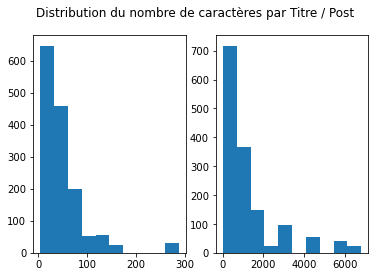

In [28]:
fig, axes = plt.subplots(1,2)
axes[0].hist(df.title_length)
axes[1].hist(df.text_length)
plt.suptitle("Distribution du nombre de caractères par Titre / Post")
plt.show()

In [215]:
s = df[df.text_length != 0]

In [211]:
s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1116 entries, 0 to 1468
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1116 non-null   object
 1   text          1116 non-null   object
 2   title_length  1116 non-null   int64 
 3   text_length   1116 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.6+ KB


(array([416., 313., 147.,  42.,  80.,   0.,  55.,  18.,  22.,  23.]),
 array([  62.,  737., 1412., 2087., 2762., 3437., 4112., 4787., 5462.,
        6137., 6812.]),
 <BarContainer object of 10 artists>)

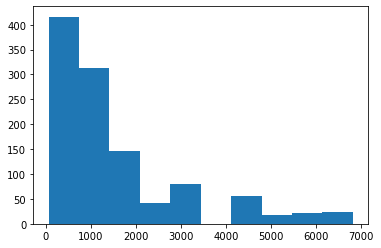

In [216]:
plt.hist(s.text_length)

## Nettoyage avec Spacy
-  Lemmatisation
-  Stopwords

In [217]:
import os
import re

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pyLDAvis

import spacy
nlp = spacy.load("en_core_web_sm")
lemmatizer = nlp.get_pipe("lemmatizer")

In [218]:
# Lemmatize le texte
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

docs = (nlp(post) for post in s.text)
corpus = []
for post in lemmatizer.pipe(docs, batch_size=50):
    corpus.append(" ".join([re.sub("[0-9]*", "", w.lemma_) for w in post if w.lemma_ not in spacy_stopwords]))

In [31]:
corpus

['',
 '',
 'sure . create throwaway . \n\n thought therapy past issue deal . \n\n life issue ... \n I place care caregiver abuse I 2 month I 7 month . alert mother abuse remove I infant caregiver . abuse include denial food , pinche , lack attention I cry , pick hold , treat roughly month .   \n\n thing I remember 3 1/2 watch mother rape knife point I . I ask man knife pee . \n\n 5 year old sexually persuade engage sexual act old cousin . \n\n 7 8 cousin . \n\n 11 upstairs neighbor attempt assault I stairway locate apartment building . \n  12 boy invite I apartment think courage I submit train ( I courage turn hostile ) \n\n 16 come home park man grab I try drag I park knife point ( thank goodness pull arm park good friend pull lead street ... I wrap pole finally . )  \n ... 22 I cousin end house guy guy ugly cousin pick bible   somewhat religious squeamish . \n\n trucker follow I car time I find street small stop follow I ... \n\n I kind therapy issue . People I I ... I guard mistrust

In [219]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Les mots qui apparaissent moins de 20 fois sont supprimés, 
vectorizer = CountVectorizer(
                            stop_words = 'english',
                            min_df=10,
                            max_features=10000,
                            )

doc_term_matrix = vectorizer.fit_transform(corpus)

## Check the Sparcity

In [220]:
# Materialize the sparse data
data_dense = doc_term_matrix.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.540802591502417 %




### LDA
le nombre de component au départ est prit au hasard car nous ne disposons pas de connaissances 
préalables sur les troubbles anxieux.

In [221]:
lda_model = LatentDirichletAllocation(n_components=5,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=666,
                                     evaluate_every = -1,
                                     n_jobs=-1,
                                     )
lda_output = lda_model.fit_transform(doc_term_matrix)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=666)


### Diagnostique du modèle

In [222]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(doc_term_matrix))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(doc_term_matrix))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -701281.2338424879
Perplexity:  402.75038842892894
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 666, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### Recherche des meilleurs paramètres

In [223]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [11, 12, 13], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_term_matrix)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [11, 12, 13]})

In [224]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_term_matrix))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 13}
Best Log Likelihood Score:  -140480.02906153566
Model Perplexity:  253.70575972018915


In [225]:
result_df = pd.DataFrame(model.cv_results_)

log_likelyhoods_5 = result_df[result_df["param_learning_decay"]==0.5]["mean_test_score"]
log_likelyhoods_7 = result_df[result_df["param_learning_decay"]==0.7]["mean_test_score"]
log_likelyhoods_9 =  result_df[result_df["param_learning_decay"]==0.9]["mean_test_score"]

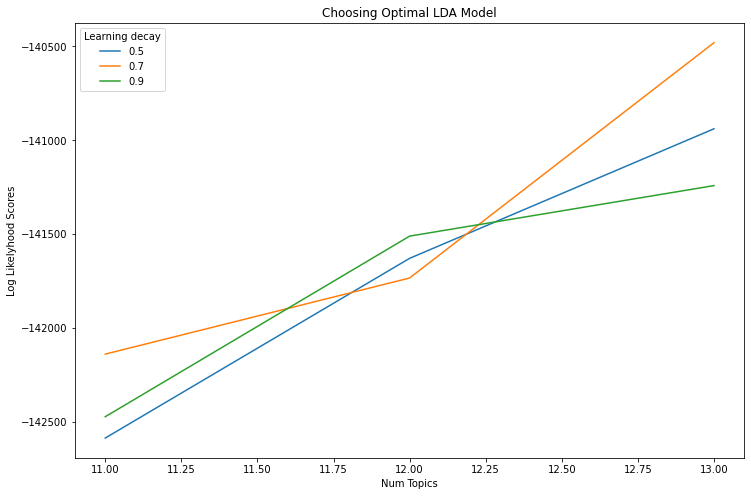

In [226]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [11, 12, 13]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [236]:
lda_model = LatentDirichletAllocation(n_components=12,
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=666,
                                     evaluate_every = -1,
                                      learning_decay=0.9,
                                     n_jobs=-1,
                                     )
lda_output = lda_model.fit_transform(doc_term_matrix)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          n_components=12, n_jobs=-1, random_state=666)


## Classifier un document selon son topic
### Vérifier le topic dominant de chaque document en regardant lequel à la plus haute contribution pour chaqun des documents

In [237]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(doc_term_matrix)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,dominant_topic
Doc0,0.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Doc1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,11
Doc2,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,7
Doc4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,0.000000,0.000000,7
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000,0.000000,10
Doc6,0.000000,0.000000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
Doc7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000,0.000000,10
Doc8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000,11
Doc9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,9


#### Distribution des topics

In [238]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,199
1,7,182
2,2,182
3,4,147
4,10,134
5,3,100
6,9,64
7,1,51
8,11,40
9,6,17


## Visualisations

In [239]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7        5.310529  171.049652       1        1  21.724215
2      136.304657   23.800941       2        1  19.359974
10     101.190552  -84.985191       3        1  13.682472
4     -106.824867  148.841736       4        1  10.552577
3      -44.365761   78.632721       5        1  10.073523
0       43.884090   73.474022       6        1   8.397883
9      114.093971  135.933029       7        1   6.157154
1     -119.727142  -72.077179       8        1   4.610738
11     -49.518208   -9.617325       9        1   2.866695
6     -141.938736   40.055210      10        1   2.419021
5       38.731544  -14.776019      11        1   0.077874
8      -10.944340 -107.193344      12        1   0.077873, topic_info=            Term         Freq        Total Category  logprob  loglift
493   experience   953.000000   953.000000  Default  30.0000  30.0000
1391    survivor   690.000000   690.000000  Default  29.0000  29.0000
635       happen   928.000000   928.000000  Default  28.0000  28.0000
830         like  1596.000000  1596.000000  Default  27.0000  27.0000
935          mum   626.000000   626.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
250         come     0.075417   416.324705  Topic12  -7.0961  -1.4583
796         know     0.076641  1890.263352  Topic12  -7.0800  -2.9553
830         like     0.074906  1596.955441  Topic12  -7.1029  -2.8095
1422       thank     0.073568   271.708567  Topic12  -7.1209  -1.0564
814        leave     0.073379   238.066740  Topic12  -7.1235  -0.9268

[792 rows x 6 columns], token_table=      Topic      Freq                                  Term
term                                                       
0         6  0.967885                          _behwrovyeut
1         9  0.916979                         _zmiedogtbrgt
3         8  0.940144                               ability
5         1  0.215443                                abroad
5         3  0.775594                                abroad
...     ...       ...                                   ...
1601      6  0.104893                                  year
1601      8  0.093705                                  year
1603      1  0.978899                                  yell
1609      1  0.983928                                    yr
1610      8  0.939415  zwjmxfjeqccbaeitjlsbaavdayrinyrwxvzq

[1177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 11, 5, 4, 1, 10, 2, 12, 7, 6, 9])

### Retrouver les mots clés des topics

In [240]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head(15)

,_behwrovyeut,_zmiedogtbrgt,abdominal,ability,able,abroad,absolutely,absorb,abstinent,abstract,...,year,yeh,yell,yep,yes,yesterday,yield,young,yr,zwjmxfjeqccbaeitjlsbaavdayrinyrwxvzq
Topic0,35.848940,0.174566,0.115307,0.156431,0.179554,0.135750,0.146574,0.114719,0.116295,0.115707,...,74.257806,0.189221,0.267409,0.207335,0.116733,0.119879,0.113661,0.183170,0.117791,0.153084
Topic1,0.118594,0.113546,0.120576,26.259401,0.112746,0.114854,0.120585,0.115287,0.118286,0.120722,...,66.595797,0.113971,0.121696,0.119939,0.128883,0.116864,0.114444,0.123003,0.118329,26.260053
Topic2,0.119449,0.123064,0.112441,0.114932,30.086011,0.123026,0.124823,0.114625,0.170825,0.132483,...,41.780424,0.136435,0.135305,0.130202,22.282846,0.121304,0.140602,62.176196,0.115945,0.124977
Topic3,0.120364,0.115693,0.119630,0.119778,0.114345,0.116534,0.123643,0.113723,0.168801,20.797035,...,73.040487,0.120999,0.112195,0.115001,20.808315,0.121023,20.803647,0.115506,0.118993,0.117536
Topic4,0.116822,0.114741,0.120470,0.122162,0.162008,0.180960,0.157830,0.128306,49.670328,0.118198,...,212.715544,0.115480,0.132051,0.129823,0.123900,0.120361,0.119751,29.612170,0.111540,0.112363
Topic5,0.114922,0.123448,0.118455,0.115212,0.191494,0.118013,0.118869,0.117764,0.112706,0.117803,...,0.119697,0.124625,0.117039,0.120116,0.116439,0.119586,0.117796,0.121569,0.117910,0.123164
Topic6,0.116587,0.114304,0.108155,0.118419,0.125752,0.137149,0.118204,0.127021,0.114923,0.122202,...,0.176359,0.143488,0.154848,0.133956,0.118736,0.112922,0.121944,0.158051,0.114872,0.116448
Topic7,0.112994,0.113634,0.111561,0.136959,0.158716,29.898193,29.879832,0.128431,0.118255,0.116418,...,140.627013,22.091826,44.081960,22.071704,0.112995,30.968879,0.113665,51.947723,49.130618,0.141469
Topic8,0.112496,0.111922,0.120649,0.119048,0.122619,0.117998,0.124000,0.116500,0.118662,0.119719,...,0.206786,0.118707,0.114039,0.117964,0.113748,0.126000,0.113256,0.118449,0.120770,0.129059
Topic9,0.121887,0.124212,0.116172,0.112801,18.233247,0.121716,0.118219,0.123702,0.121570,0.120969,...,0.264531,0.119053,0.126676,0.121577,0.122932,0.123387,0.124214,0.132852,0.120488,0.124791


In [241]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,experience,feel,assault,sexual,survivor,card,gift,want,domestic,abuse,time,know,violence,survey,complete
Topic 1,participate,research,survivor,help,survey,sexual,understand,https,adult,study,seek,year,old,link,card
Topic 2,know,friend,feel,time,happen,guy,relationship,want,let,love,nt,assault,sexual,think,home
Topic 3,hate,know,want,time,hope,good,feel,like,think,thing,try,tell,life,friend,fall
Topic 4,like,feel,year,know,therapy,help,tell,happen,assault,july,rape,think,abuser,issue,cousin
Topic 5,thing,life,fail,good,parent,live,seriously,continue,owe,like,hurtful,try,know,people,guide
Topic 6,bf,happen,like,know,afraid,activity,dog,fine,way,think,behave,nervous,kiss,problem,bit
Topic 7,mum,tell,time,think,know,like,dad,brother,car,want,guy,come,start,ask,abuse
Topic 8,participate,sexual,experience,year,survey,understand,help,https,assault,seek,com,address,violence,behavior,feeling
Topic 9,survivor,woman,experience,letter,help,post,violence,sexual,healing,hear,story,want,personal,path,resource


# Prédire le topic pour un nouveau Tweet

In [23]:
# # Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

# def predict_topic(text, nlp=nlp):
#     global sent_to_words
#     global lemmatization

#     # Step 1: Clean with simple_preprocess
#     mytext_2 = list(sent_to_words(text))

#     # Step 2: Lemmatize
#     mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#     # Step 3: Vectorize transform
#     mytext_4 = vectorizer.transform(mytext_3)

#     # Step 4: LDA Transform
#     topic_probability_scores = best_lda_model.transform(mytext_4)
#     topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
#     return topic, topic_probability_scores

# # Predict the topic
# mytext = ["Some text about christianity and bible"]
# topic, prob_scores = predict_topic(text = mytext)
# print(topic)

Component's weights: 
 [[ 1.    0.01  0.04  0.01  0.02  0.    0.    0.06  0.    0.01  0.02  0.  ]
 [-0.07  0.    0.2   0.01  0.04  0.    0.    0.98  0.    0.04  0.01  0.  ]]
Perc of Variance Explained: 
 [0.16 0.15]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

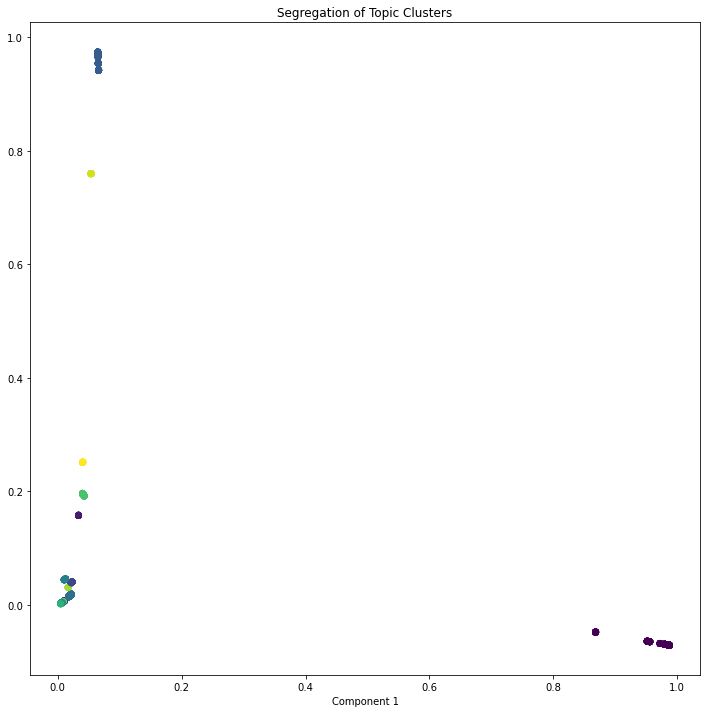

In [242]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

2938

In [159]:
lda_model = LatentDirichletAllocation(n_components=13, random_state=888)
lda_model.fit(doc_term_matrix)
data = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(data)

In [64]:
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure 

print(len(s.at_risk),(df_document_topic.dominant_topic == 0).sum())
print(adjusted_rand_score(s.at_risk, df_document_topic.dominant_topic))
print(homogeneity_completeness_v_measure(s.at_risk, df_document_topic.dominant_topic))

AttributeError: 'DataFrame' object has no attribute 'at_risk'

In [64]:
print(adjusted_rand_score(s.at_risk, clusters))
print(homogeneity_completeness_v_measure(s.at_risk, clusters))

0.01875663753668492
(0.01657227043428461, 0.018506812715573626, 0.017486198478387695)


In [206]:
df.iloc[1,3]

0